In [ ]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import gdown
md5 = '6cd6e144f989b92b3379bac3b3de84fd'
#url = 'https://drive.google.com/file/d/14eyB2lkxrG83fGy4t395sgZqADOYJ_yE/view?usp=sharing'
url = 'https://drive.google.com/uc?id=14eyB2lkxrG83fGy4t395sgZqADOYJ_yE'
output = '/mydrive/data/VOCtrainval_11-May-2012.tar'
gdown.cached_download(url, output, md5=md5)

Cached Downloading: /mydrive/data/VOCtrainval_11-May-2012.tar
Downloading...
From: https://drive.google.com/uc?id=14eyB2lkxrG83fGy4t395sgZqADOYJ_yE
To: /root/.cache/gdown/tmpjaifjo18/dl
100%|██████████| 2.00G/2.00G [00:17<00:00, 114MB/s]


Computing MD5: /mydrive/data/VOCtrainval_11-May-2012.tar
MD5 matches: /mydrive/data/VOCtrainval_11-May-2012.tar


'/mydrive/data/VOCtrainval_11-May-2012.tar'

In [ ]:
!tar xf /mydrive/data/VOCtrainval_11-May-2012.tar

In [2]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/data

ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/data


In [3]:
!ln -s VOCdevkit data

ln: failed to create symbolic link 'data/VOCdevkit': File exists


In [ ]:
!ls

2012_train.txt	data	    model.png	       VOCdevkit
2012_val.txt	model_data  voc_annotation.py  VOCtrainval_11-May-2012.tar


In [27]:
#!python voc_annotation.py
import xml.etree.ElementTree as ET
from os import getcwd

#sets=[('2012', 'train'), ('2012', 'val'), ('2012', 'test')]
sets=[('2012', 'train'), ('2012', 'val')]
#sets=[('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


def convert_annotation(year, image_id, list_file):
    in_file = open('data/VOC%s/Annotations/%s.xml'%(year, image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

wd = '/mydrive/data'

for year, image_set in sets:
    image_ids = open('data/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(year, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/data/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
        convert_annotation(year, image_id, list_file)
        list_file.write('\n')
    list_file.close()



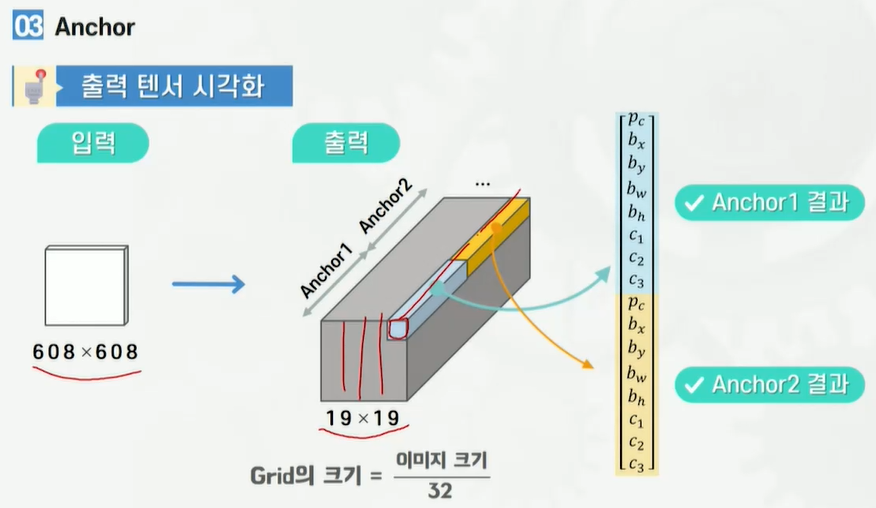

In [3]:
from functools import wraps

import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Add, ZeroPadding2D, UpSampling2D, Concatenate, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [4]:
class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        config = super(Mish, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

In [5]:
"""Miscellaneous utility functions."""

from functools import reduce

from PIL import Image
import numpy as np
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.
    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

In [6]:
def DarknetCBM(x, filters: int, kernel_size: int, is_downsample: bool):
  stride = (2, 2) if is_downsample is True else (1, 1)
  padding = 'valid' if is_downsample is True else 'same'
  #padding = 'same'
  return compose(Conv2D(filters, kernel_size, strides=stride, padding=padding, use_bias=False),
       BatchNormalization(),
       Mish())(x)          
  #x = Conv2D(filters, kernel_size, strides=stride, padding=padding, use_bias=False)(x)
  #x = BatchNormalization()(x)
  #x = Mish()(x)
  #return x

def DarknetCBL(x, filters: int, kernel_size: int, is_downsample: bool):
  stride = (2, 2) if is_downsample is True else (1, 1)
  padding = 'valid' if is_downsample is True else 'same'
  #padding = 'same'
  return compose(Conv2D(filters, kernel_size, strides=stride, padding=padding, use_bias=False),
       BatchNormalization(),
       LeakyReLU(alpha=0.1))(x)
  #x = Conv2D(filters, kernel_size, strides=stride, padding=padding, use_bias=False)(x)
  #x = BatchNormalization()(x)
  #x = LeakyReLU(alpha=0.1)(x)
  #return x

def CSPBlock(x, filters, num_blocks):
  # keras의 same은
  # same은 좌우 동일하게 padding 1을 추가하되 
  # 최종 사이즈가 홀수가 나오는 경우 짝수로 맞추어주기 위해 우측에 padding 2를 추가
  # 고로 strides=2(다크넷이 지정)를 주면서 다운샘플링을 하려면
  # padding='same'을 주거나 (pad=1, stride=2는 다운샘플링 됨)
  # padding='valid'에 zeropadding을 추가하면 됨 (size +1, pad=0, stride=2도 다운샘플링)

  x = ZeroPadding2D(((1,0),(1,0)))(x)
  base_conv = DarknetCBM(x, filters, 3, True)

  x = DarknetCBM(base_conv, filters//2 if filters != 64 else filters, 1, False)
  short_conv = x
  for i in range(num_blocks):
    x = DarknetCBM(x, filters//2, 1, False)
    x = DarknetCBM(x, filters//2 if filters != 64 else filters, 3, False)
    short_conv = Add()([short_conv, x])

  post_conv = DarknetCBM(x, filters//2 if filters != 64 else filters, 1, False)
  short_conv = DarknetCBM(base_conv, filters//2 if filters != 64 else filters, 1, False)

  route = Concatenate()([post_conv, short_conv])
  return DarknetCBM(route, filters, 1, False)


In [7]:

def make_darknet(inputs, num_achors, num_classes):
  ### Body
  x = inputs
  x = DarknetCBM(x, 32, 3, False)
  x = CSPBlock(x, 64, 1)
  x = CSPBlock(x, 128, 2)
  x = CSPBlock(x, 256, 8)
  csp256 = x
  x = CSPBlock(x, 512, 8)
  csp512 = x
  x = CSPBlock(x, 1024, 4)

  ### SPP + PANet

  ## CBL + SPP + CBL
  # CBL x3
  x = DarknetCBL(x, 512, 1, False)
  x = DarknetCBL(x, 1024, 3, False)
  x = DarknetCBL(x, 512, 1, False)
  # SPP
  maxpool1 = MaxPooling2D(pool_size=(13,13), strides=(1,1), padding='same')(x)
  maxpool2 = MaxPooling2D(pool_size=(9,9), strides=(1,1), padding='same')(x)
  maxpool3 = MaxPooling2D(pool_size=(5,5), strides=(1,1), padding='same')(x)
  x = Concatenate()([maxpool1, maxpool2, maxpool3, x])
  # CBL x3
  x = DarknetCBL(x, 512, 1, False)
  x = DarknetCBL(x, 1024, 3, False)
  x = DarknetCBL(x, 512, 1, False)
  spp_cbl_3 = x
  ## End of CBL + SPP + CBL

  ##### 아래에서 위로 #####

  # CBL + Upsample
  x = DarknetCBL(x, 256, 1, False)
  x = UpSampling2D(2)(x)
  upsample_256 = x

  # Route + CBL + Concate
  x = DarknetCBL(csp512, 256, 1, False)
  x = Concatenate()([x, upsample_256])

  # CBL x5
  x = DarknetCBL(x, 256, 1, False)
  x = DarknetCBL(x, 512, 3, False)
  x = DarknetCBL(x, 256, 1, False)
  x = DarknetCBL(x, 512, 3, False)
  x = DarknetCBL(x, 256, 1, False)

  cbl_5 = x

  # CBL + Upsample
  x = DarknetCBL(x, 128, 1, False)
  x = UpSampling2D(2)(x)
  upsample_128 = x

  # Route + CBL + Concate
  x = DarknetCBL(csp256, 128, 1, False)
  x = Concatenate()([x, upsample_128])

  ##### 다시 위에서 아래로 #####

  # CBL x5
  x = DarknetCBL(x, 128, 1, False)
  x = DarknetCBL(x, 256, 3, False)
  x = DarknetCBL(x, 128, 1, False)
  x = DarknetCBL(x, 256, 3, False)
  x = DarknetCBL(x, 128, 1, False)

  ### 1st output ###
  output_1 = DarknetCBL(x, 256, 3, False)
  output_1 = Conv2D(num_achors*(num_classes+5), (1,1), use_bias=True)(output_1)
  # output의 shape은 size x size x anchor수 x (p + x + y + w + h + classes) 
  # 즉, class 갯수가 10이라면 size x size x anchor수 x (1 + 4 + 10) = size x size x 45

  # CBL down-sample
  x = ZeroPadding2D(((1,0),(1,0)))(x)
  x = DarknetCBL(x, 256, 3, True)
  x = Concatenate()([x, cbl_5])

  # CBL x5
  x = DarknetCBL(x, 256, 1, False)
  x = DarknetCBL(x, 512, 3, False)
  x = DarknetCBL(x, 256, 1, False)
  x = DarknetCBL(x, 512, 3, False)
  x = DarknetCBL(x, 256, 1, False)

  ### 2nd output ###
  output_2 = DarknetCBL(x, 512, 3, False)
  output_2 = Conv2D(num_achors*(num_classes+5), (1,1), use_bias=True)(output_2)

  # CBL down-sample
  x = ZeroPadding2D(((1,0),(1,0)))(x)
  x = DarknetCBL(x, 512, 3, True)
  x = Concatenate()([x, spp_cbl_3])

  # CBL x5
  x = DarknetCBL(x, 512, 1, False)
  x = DarknetCBL(x, 1024, 3, False)
  x = DarknetCBL(x, 512, 1, False)
  x = DarknetCBL(x, 1024, 3, False)
  x = DarknetCBL(x, 512, 1, False)

  ### 3rd output ###
  output_3 = DarknetCBL(x, 1024, 3, False)
  output_3 = Conv2D(num_achors*(num_classes+5), (1,1), use_bias=True)(output_3)

  darknet = Model(inputs, [output_3, output_2, output_1])

  return darknet

In [8]:
anchors_stride_base = np.array([
        [[12, 16], [19, 36], [40, 28]],
        [[36, 75], [76, 55], [72, 146]],
        [[142, 110], [192, 243], [459, 401]]
    ])
anchors_stride_base = anchors_stride_base.astype(np.float32)
anchors_stride_base[0] /= 8
anchors_stride_base[1] /= 16
anchors_stride_base[2] /= 32
num_classes = 10

In [9]:
inputs = Input(shape=(608, 608, 3), name='input_0')

model = make_darknet(inputs, len(anchors_stride_base), num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_0 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_0[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
tf.keras.utils.plot_model( model, show_shapes=True)

# IOU LOSS

## IoU Loss
* IoU 자체를 손실함수로 사용한다.
* 이 방법은 더이상 사용되지 않는다. 겹치지 않는 경우 0이 되므로 무조건 1로 학습이 진행되지 않는다.

## D-IoU Loss
* 따라서 거리의 penalty를 줌으로써 떨어진 경우에도 손실이 발생하도록 한다.
* (^x-x)^2 + (^y-y)^2
* 정확한 유클리디안 거리는 루트를 씌워야 하지만 계산이 복잡해지므로 그럴 필요가 없음
* normalization을 위해 전체 박스의 대각선 거리의 제곱으로 나눔

## C-IoU Loss
* D-IoU + aspect ratio도 고려
* 가로로 긴 사각형, 세로로 긴 사격형이냐에 따라 손실값이 추가되도록
* ^w/^h를 tangent inverse 취해서 차의 제곱을 하고 normalization을 하면 aspect ratio에 따라 0~1사의 값을 갖게 된다.
* 여기서 v에서 tangent inverse (=arctan)이 등장한다. arctan 0 = 0이고 arctan1은 π/4 이고, arctan∞은 π/2이다.
* 최대로 차이 날 경우를 살펴보자.
 * 추론박스가 세로로 길면 arctan w/h는 0에 가까울 것. 정답박스가 가로로 길면 arctan w/h는 π/2가 될 것이다. 차의 제곱을 하면 π^2/4가 되고, 수식 앞의 4/π^2과 곱하면 1로 떨어진다. 그렇다 극단적인 경우 1이 되는 것.
 * 동일하다고 했을 때는 당연히 0이 되는 것.

* 이 v를 a와 곱해서 더해준다.
* a는 iou가 1이면 1(즉, 최대치로 사용), iou가 0에 가까우면 0에 가깝게 된다.

 <img src="https://p3-juejin.byteimg.com/tos-cn-i-k3u1fbpfcp/930e98b464eb4d74aeff6ec71700be99~tplv-k3u1fbpfcp-watermark.awebp?"></img>

# BOX LOSS 
* box scale은 최악의 경우(GT가 인풋아웃전체크기)여도 1이며 일반적으로 그보다 작으므로 1.1~1.9 범위가 나온다. 즉 1 이상으로 곱해지므로 ciou가 거의 그대로 반영되면서 GT작을수록 좀더 크게 반영됨을 알 수 있음
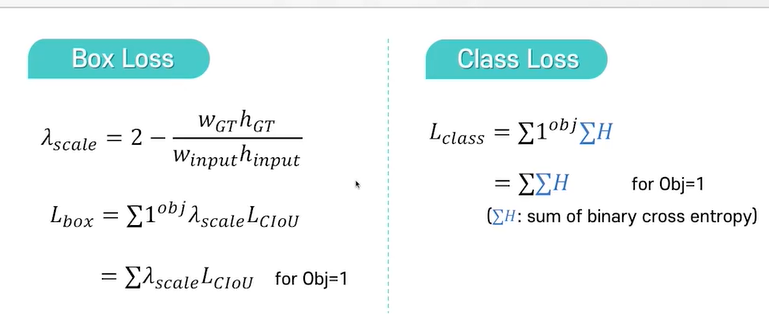
# CLASS LOSS
* 각 클래스에 대해 binary cross entrophy를 사용한다.
* obj가 1인 것에 대해 binary cross entrophy를 다 더해주면 됨

# Confidence Loss (object가 있는가 없는가)
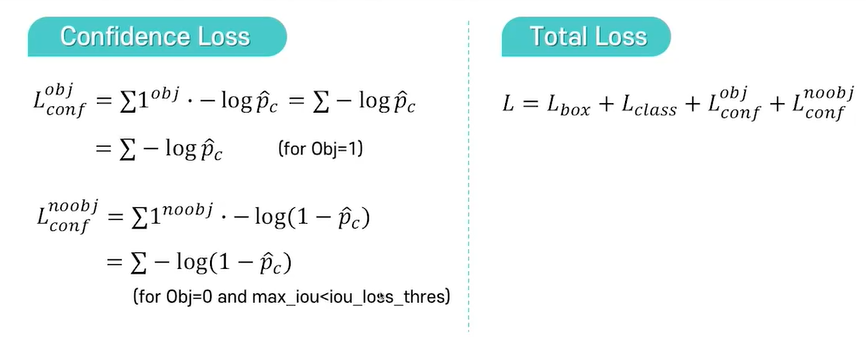
* 오브젝트가 있을 때는 -log ^p
* 오브젝트가 없을 경우에는 -log(1-^p).


# TOTAL LOSS
* object가 있을 경우 Lbox + Lclass + Lobj conf + Lnoobj conf
* object가 없을 경우 Lnoobj conf만 계산


In [ ]:
def bbox_ciou(boxes1, boxes2):
    '''
    caluate ciou = iou - p2/c2 - av
    : (batch_size, grid_r, grid_c, anchor, box)
    :param boxes1: (8, 13, 13, 3, 4)   pred_xywh
    :param boxes2: (8, 13, 13, 3, 4)   label_xywh
    :return:

    For example, assume that the shapes of pred_xywh and label_xywh are both (1, 4)
    '''

    # 최종적으로 뽑아지는 boxes 값은 [x, y, w, h] 형태이다. loss 계산을 위해 [x1, y1, x2, y2] 형태로 변경하는 작업을 한다.
    boxes1_x0y0x1y1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                                 boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2_x0y0x1y1 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                                 boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)
    '''
    Compare boxes1_x0y0x1y1[..., :2] and boxes1_x0y0x1y1[..., 2:] position by position, that is, compare [x0, y0] and [x1, y1] position by position, leaving the smaller ones.
    For example, leaving [x0, y0]
    This step is to avoid that w h is a negative number at the beginning, causing x0y0 to become the coordinates of the lower right corner and x1y1 to become the coordinates of the upper left corner.
    '''

    # x1, y1, x2, y2에서 앞 두가지가 작은 값이고 뒤 두가지가 큰 값이 되도록 한번더 처리하는 작업
    boxes1_x0y0x1y1 = tf.concat([tf.minimum(boxes1_x0y0x1y1[..., :2], boxes1_x0y0x1y1[..., 2:]),
                                 tf.maximum(boxes1_x0y0x1y1[..., :2], boxes1_x0y0x1y1[..., 2:])], axis=-1)
    boxes2_x0y0x1y1 = tf.concat([tf.minimum(boxes2_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., 2:]),
                                 tf.maximum(boxes2_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., 2:])], axis=-1)

    # 이 두 박스의 각 넓이를 구한다.
    boxes1_area = (boxes1_x0y0x1y1[..., 2] - boxes1_x0y0x1y1[..., 0]) * (
                boxes1_x0y0x1y1[..., 3] - boxes1_x0y0x1y1[..., 1])
    boxes2_area = (boxes2_x0y0x1y1[..., 2] - boxes2_x0y0x1y1[..., 0]) * (
                boxes2_x0y0x1y1[..., 3] - boxes2_x0y0x1y1[..., 1])

    # The coordinates of the upper left corner and the lower right corner of the intersecting rectangle, the shapes are both (8, 13, 13, 3, 2)
    # 두 박스의 겹치는 영역을 구한다.
    # 두박스의 x1, x1의 최대값, y1, y1의 최대값을 구하면 겹치는 영역의 left, top 이 된다.
    # 두박스의 x2, x2의 최소값, y2, y2의 최소값을 구하면 겹치는 영역의 right, bottom이 된다.
    left_up = tf.maximum(boxes1_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., :2])
    right_down = tf.minimum(boxes1_x0y0x1y1[..., 2:], boxes2_x0y0x1y1[..., 2:])

    # IOU를 구하자
    # 겹치는 영역의 w, h를 구하는데, 무조건 0보다는 크도록
    inter_section = tf.maximum(right_down - left_up, 0.0)
    # 겹치는 영역의 넓이를 구함
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    # 두박스의 넓이를 더한 후 겹치는 영역을 빼주면 전체 넓이
    union_area = boxes1_area + boxes2_area - inter_area
    # iou를 구한다.
    iou = inter_area / (union_area + K.epsilon())

    # The coordinates of the upper left corner and the lower right corner of the enclosing rectangle, the shape is (8, 13, 13, 3, 2)
    # 두 박스를 담고 있는 전체 영역 좌표를 구한다.
    # 두 박스의 x,y의 최소값을 구하면 left, top
    # 두 박스의 x,y의 최대값을 구하면 right, bottom
    enclose_left_up = tf.minimum(boxes1_x0y0x1y1[..., :2], boxes2_x0y0x1y1[..., :2])
    enclose_right_down = tf.maximum(boxes1_x0y0x1y1[..., 2:], boxes2_x0y0x1y1[..., 2:])

    ## DIoU 계산 ##
    # 전체 영역의 w, h를 구함
    enclose_wh = enclose_right_down - enclose_left_up
    # w 제곱 + h 제곱을 구해서 대각선 길이에 해당하는 c를 구한다. 
    enclose_c2 = K.pow(enclose_wh[..., 0], 2) + K.pow(enclose_wh[..., 1], 2)
    
    # The square of the distance between the center points of the two rectangles
    # 두 박스의 x1, x2 차의 제곱 + y1, y2 차의 제곱을 구한다.
    p2 = K.pow(boxes1[..., 0] - boxes2[..., 0], 2) + K.pow(boxes1[..., 1] - boxes2[..., 1], 2)

    # Increase av. Add division by 0 protection to prevent nan.
    # 박스1의 w / h에 arc tangent 취함
    # 박스2의 w / h에 arc tangent 취함
    atan1 = tf.atan(boxes1[..., 2] / (boxes1[..., 3] + K.epsilon()))
    atan2 = tf.atan(boxes2[..., 2] / (boxes2[..., 3] + K.epsilon()))
    # v를 구한다.
    # arctan1 - arctan2의 제곱 x 4 / pi제곱 
    v = 4.0 * K.pow(atan1 - atan2, 2) / (math.pi ** 2)
    # v로 a를 구한다.
    a = v / (1 - iou + v)

    # ciou loss = 1 - ciou
    # 수식에는 모든 항이 +로 되어 있는데, 여기서는 -인 이유는 1 - ciou로 풀었을 때 -가 되기 때문
    ciou = iou - 1.0 * p2 / enclose_c2 - 1.0 * a * v
    return ciou

def bbox_iou(boxes1, boxes2):
    # bbox iou 구하는 유틸 함수
    '''
    Measuring frame boxes1 (?, grid_h, grid_w, 3, 1, 4), the output of the neural network (tx, ty, tw, th) is obtained by post-processing (bx, by, bw, bh)
    All gt boxes2 in the picture (?, 1, 1, 1, 150, 4)
    '''

    boxes1_area = boxes1[..., 2] * boxes1[..., 3]  # Area of 3 prediction boxes of all grids
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]  # The area of all ground truth

    # (x, y, w, h) to (x0, y0, x1, y1)
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    # 3 prediction boxes with grids and 150 ground truth calculation iou respectively. So the shape of left_up and right_down = (?, grid_h, grid_w, 3, 150, 2)
    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])  # The coordinates of the upper left corner of the intersecting rectangle
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])  # The coordinates of the lower right corner of the intersecting rectangle

    inter_section = tf.maximum(right_down - left_up, 0.0)  # The w and h of the intersecting rectangle are 0 when they are negative (?, grid_h, grid_w, 3, 150, 2)
    inter_area = inter_section[..., 0] * inter_section[..., 1]  # Area of the intersecting rectangle (?, grid_h, grid_w, 3, 150)
    union_area = boxes1_area + boxes2_area - inter_area  # union_area      (?, grid_h, grid_w, 3, 150)
    iou = 1.0 * inter_area / union_area  # iou                             (?, grid_h, grid_w, 3, 150)
    return iou

def loss_layer(conv, pred, label, bboxes, stride, num_class, iou_loss_thresh):
    conv_shape = tf.shape(conv)
    batch_size = conv_shape[0] # 배치
    output_size = conv_shape[1] # 사이즈
    input_size = stride * output_size
    # 1차원의 feature를 (batch, size, size, 3, 5 + num_class) 로 reshape!
    conv = tf.reshape(conv, (batch_size, output_size, output_size,
                             3, 5 + num_class))
    
    # 0~4 : p, x, y, w, h
    # 5부터 class 확률
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh = pred[:, :, :, :, 0:4] # 박스 좌표
    pred_conf = pred[:, :, :, :, 4:5] # 컨피던스

    label_xywh = label[:, :, :, :, 0:4] # 라벨의 박스 좌표
    respond_bbox = label[:, :, :, :, 4:5] # 있나없나
    label_prob = label[:, :, :, :, 5:] # 라벨의 확률

    ciou = tf.expand_dims(bbox_ciou(pred_xywh, label_xywh), axis=-1)  # (8, 13, 13, 3, 1)
    input_size = tf.cast(input_size, tf.float32)

    # The weight of each prediction box xxxiou_loss = 2-(ground truth area/picture area)
    # Box Loss 계산을 위해 먼저 Box Loss Scale을 구한다.
    # 실제 정답 크기를 입력 사이즈로 나누어서 2에서 빼준다.
    # 동일하다면 1이고, GT가 클수록 0에 가까워지고, GT가 작을수록 2에 가까워짐
    # 즉, GT가 작을수록 loss를 더 크게..?
    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    # 오브젝트 있는 것들만 계산해서 합산
    ciou_loss = respond_bbox * bbox_loss_scale * (1 - ciou) # 1. respond_bbox is used as a mask, xxxiou_loss is calculated only when there is an object
    
    # 2. respond_bbox is used as a mask, and the category loss is calculated when there is an object
    # 최종레이어에서 받아들이는 값은 로짓이고 해당 값을 아웃풋으로 sigmoid
    # https://westshine-data-analysis.tistory.com/83 (엔트로피, 크로스엔트로피)
    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    # 3. xxxiou_loss and category loss are relatively simple. The important thing is conf_loss, which is a focal_loss
    # There are two steps: the first step is to determine which grid_h * grid_w * 3 prediction boxes are used as counterexamples; the second step is to calculate focal_loss.
    # np.newaxis를 넣으면 차원을 1로 하면서 늘어나는 효과 3, 150으로 iou를 계산해야 3개씩 iou의 최대값을 구한다. 자세히 살펴봐야 할듯
    expand_pred_xywh = pred_xywh[:, :, :, :, np.newaxis, :]  # Expand to (?, grid_h, grid_w, 3,   1, 4)
    expand_bboxes = bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :]  # Expand to (?,      1,      1, 1, 150, 4) => 미리 지정한 150은 최대 박스 갯수
    iou = bbox_iou(expand_pred_xywh, expand_bboxes)  # The 3 prediction boxes of all grids and 150 ground truth respectively calculate iou.   (?, grid_h, grid_w, 3, 150
    # conf loss를 구하기 위해서 max iou가 필요함
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)  # Among 150 ground truth iou, keep the largest iou. (?, grid_h, grid_w, 3, 1)

    # respond_bgd represents whether the grid_h * grid_w * 3 prediction boxes output by this branch are counterexamples (background)
    # label has an object, respond_bgd is 0. If there is no object: if the iou with a certain gt (150 in total) exceeds iou_loss_thresh, respond_bgd is 0; if the iou with all gt (150 at most) is less than iou_loss_thresh, respond_bgd is 1.
    # respond_bgd is 0 means there is an object, which is not a counterexample; the weight respond_bgd is 1 means there is no object, which is a counterexample.
    # Interestingly, due to constant updates during model training, for the same picture, the grid_h * grid_w * 3 prediction boxes (for this branch output) of the two predictions are different. These prediction boxes are used to calculate iou to determine which prediction boxes are counterexamples.
    # Instead of using a priori box of fixed size (not fixed position).
    respond_bgd = (1.0 - respond_bbox) * tf.cast(max_iou < iou_loss_thresh, tf.float32)

    # Binary cross entropy loss
    # Confidence Loss를 구한다.
    # 오브젝트가 있는 경우의 로스, 오브젝트가 없는 경우의 로스
    # 오브젝트가 있는 경우는 확률이 높을 수록 loss가 낮아야 하므로 엔트로피 적용
    # respnd_bbox는 있는 경우에만 1이므로 있는 경우의 loss값만 계산됨
    pos_loss = respond_bbox * (0 - K.log(pred_conf + K.epsilon()))
    # 오브젝트가 없는 경우는 확률이 높을 수록 loss가 높으므로 -log(1-p)이고 
    # respond_bgd는 max_iou < iou_loss_thresh 일 때만 동작하게 하기 위한 장치임
    neg_loss = respond_bgd  * (0 - K.log(1 - pred_conf + K.epsilon()))
    # 둘을 합쳐 conf loss
    conf_loss = pos_loss + neg_loss
    # Looking back at respond_bgd, the iou of a certain prediction box and a certain gt exceeds iou_loss_thresh, which is not regarded as a counterexample. When participating in the "Binary Cross Entropy of Predicted Confidence Level and True Confidence Level", this box may not be a positive example (if this box is not marked as 1 in the label). This box may not participate in the calculation of confidence loss.
    # This kind of box is generally the box near the gt box, or the other two boxes of the grid where the gt box is located. It is neither a positive example nor a negative example. It does not participate in the calculation of the confidence loss. (Called ignore in the paper

    ciou_loss = tf.reduce_mean(tf.reduce_sum(ciou_loss, axis=[1, 2, 3, 4]))  # Each sample calculates its own ciou_loss separately, and then averages
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1, 2, 3, 4]))  # Each sample calculates its own conf_loss separately, and then averages
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1, 2, 3, 4]))  # Each sample calculates its own prob_loss separately, and then averages

    return ciou_loss, conf_loss, prob_loss

# YOLO의 모델 출력 결과를 scale및 grid에 따라 좌표 복원하기
# conf(objectness)와 prob(class probability)에는 sigmoid activation function 적용
# 전체가 convolution이라서 부분적으로 activation을 후처리함.

def decode(conv_output, anchors, stride, num_class):
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]
    anchor_per_scale = len(anchors)
    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, anchor_per_scale, 5 + num_class))
    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    conv_raw_prob = conv_output[:, :, :, :, 5: ]
    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])
    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, anchor_per_scale, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * stride
    pred_wh = (tf.exp(conv_raw_dwdh) * anchors) * stride
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

# 전체 loss 계산 함수

def yolo_loss(args, num_classes, iou_loss_thresh, anchors):
    conv_lbbox = args[0]   # (?, ?, ?, 3*(num_classes+5))
    conv_mbbox = args[1]   # (?, ?, ?, 3*(num_classes+5))
    conv_sbbox = args[2]   # (?, ?, ?, 3*(num_classes+5))
    label_sbbox = args[3]   # (?, ?, ?, 3, num_classes+5)
    label_mbbox = args[4]   # (?, ?, ?, 3, num_classes+5)
    label_lbbox = args[5]   # (?, ?, ?, 3, num_classes+5)
    true_sbboxes = args[6]   # (?, 150, 4)
    true_mbboxes = args[7]   # (?, 150, 4)
    true_lbboxes = args[8]   # (?, 150, 4)
    pred_sbbox = decode(conv_sbbox, anchors[0], 8, num_classes)
    pred_mbbox = decode(conv_mbbox, anchors[1], 16, num_classes)
    pred_lbbox = decode(conv_lbbox, anchors[2], 32, num_classes)
    sbbox_ciou_loss, sbbox_conf_loss, sbbox_prob_loss = loss_layer(conv_sbbox, pred_sbbox, label_sbbox, true_sbboxes, 8, num_classes, iou_loss_thresh)
    mbbox_ciou_loss, mbbox_conf_loss, mbbox_prob_loss = loss_layer(conv_mbbox, pred_mbbox, label_mbbox, true_mbboxes, 16, num_classes, iou_loss_thresh)
    lbbox_ciou_loss, lbbox_conf_loss, lbbox_prob_loss = loss_layer(conv_lbbox, pred_lbbox, label_lbbox, true_lbboxes, 32, num_classes, iou_loss_thresh)

    ciou_loss = sbbox_ciou_loss + mbbox_ciou_loss + lbbox_ciou_loss
    conf_loss = sbbox_conf_loss + mbbox_conf_loss + lbbox_conf_loss
    prob_loss = sbbox_prob_loss + mbbox_prob_loss + lbbox_prob_loss

    loss = ciou_loss + conf_loss + prob_loss

    loss = tf.compat.v1.Print(loss, [loss, ciou_loss, conf_loss, prob_loss], message=' loss: ')
    #tf.print([loss, ciou_loss, conf_loss, prob_loss])

    return loss

In [ ]:
def create_model(input_shape, anchors_stride_base, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors_stride_base)

    max_bbox_per_scale = 150
    iou_loss_thresh = 0.7

    model_body = make_darknet(image_input, num_anchors, num_classes)
    print('Create YOLOv4 model with {} anchors and {} classes.'.format(num_anchors*3, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (250, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))
    
    y_true = [
        layers.Input(name='input_2', shape=(None, None, 3, (num_classes + 5))),  # label_sbbox
        layers.Input(name='input_3', shape=(None, None, 3, (num_classes + 5))),  # label_mbbox
        layers.Input(name='input_4', shape=(None, None, 3, (num_classes + 5))),  # label_lbbox
        layers.Input(name='input_5', shape=(max_bbox_per_scale, 4)),             # true_sbboxes
        layers.Input(name='input_6', shape=(max_bbox_per_scale, 4)),             # true_mbboxes
        layers.Input(name='input_7', shape=(max_bbox_per_scale, 4))              # true_lbboxes
    ]
    loss_list = layers.Lambda(yolo_loss, name='yolo_loss',
                           arguments={'num_classes': num_classes, 'iou_loss_thresh': iou_loss_thresh,
                                      'anchors': anchors_stride_base})([*model_body.output, *y_true])

    model = Model([model_body.input, *y_true], loss_list)
    #model.summary()

    return model, model_body

In [ ]:
!cat model_data/voc_classes.txt
!cat model_data/yolo4_anchors.txt

aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor
12, 16,  19, 36,  40, 28,  36, 75,  76, 55,  72, 146,  142, 110,  192, 243,  459, 401

In [ ]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

# Data Augmentation

In [ ]:
def random_fill(image, bboxes):
    if random.random() < 0.5:
        h, w, _ = image.shape
        # Fill the black border horizontally to train small target detection
        if random.random() < 0.5:
            dx = random.randint(int(0.5*w), int(1.5*w))
            black_1 = np.zeros((h, dx, 3), dtype='uint8')
            black_2 = np.zeros((h, dx, 3), dtype='uint8')
            image = np.concatenate([black_1, image, black_2], axis=1)
            bboxes[:, [0, 2]] += dx
        # Fill the black edges vertically to train small target detection
        else:
            dy = random.randint(int(0.5*h), int(1.5*h))
            black_1 = np.zeros((dy, w, 3), dtype='uint8')
            black_2 = np.zeros((dy, w, 3), dtype='uint8')
            image = np.concatenate([black_1, image, black_2], axis=0)
            bboxes[:, [1, 3]] += dy
    return image, bboxes

def random_horizontal_flip(image, bboxes):
    if random.random() < 0.5:
        _, w, _ = image.shape
        image = image[:, ::-1, :]
        bboxes[:, [0,2]] = w - bboxes[:, [2,0]]
    return image, bboxes

def random_crop(image, bboxes):
    if random.random() < 0.5:
        h, w, _ = image.shape
        max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

        max_l_trans = max_bbox[0]
        max_u_trans = max_bbox[1]
        max_r_trans = w - max_bbox[2]
        max_d_trans = h - max_bbox[3]

        crop_xmin = max(0, int(max_bbox[0] - random.uniform(0, max_l_trans)))
        crop_ymin = max(0, int(max_bbox[1] - random.uniform(0, max_u_trans)))
        crop_xmax = max(w, int(max_bbox[2] + random.uniform(0, max_r_trans)))
        crop_ymax = max(h, int(max_bbox[3] + random.uniform(0, max_d_trans)))

        image = image[crop_ymin : crop_ymax, crop_xmin : crop_xmax]

        bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - crop_xmin
        bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - crop_ymin
    return image, bboxes

def random_translate(image, bboxes):
    if random.random() < 0.5:
        h, w, _ = image.shape
        max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

        max_l_trans = max_bbox[0]
        max_u_trans = max_bbox[1]
        max_r_trans = w - max_bbox[2]
        max_d_trans = h - max_bbox[3]

        tx = random.uniform(-(max_l_trans - 1), (max_r_trans - 1))
        ty = random.uniform(-(max_u_trans - 1), (max_d_trans - 1))

        M = np.array([[1, 0, tx], [0, 1, ty]])
        image = cv2.warpAffine(image, M, (w, h))

        bboxes[:, [0, 2]] = bboxes[:, [0, 2]] + tx
        bboxes[:, [1, 3]] = bboxes[:, [1, 3]] + ty
    return image, bboxes

def image_preprocess(image, target_size, gt_boxes):
    # The images passed in for training are in rgb format
    ih, iw = target_size
    h, w = image.shape[:2]
    interps = [   # Randomly choose an interpolation method
        cv2.INTER_NEAREST,
        cv2.INTER_LINEAR,
        cv2.INTER_AREA,
        cv2.INTER_CUBIC,
        cv2.INTER_LANCZOS4,
    ]
    method = np.random.choice(interps)   # Randomly choose an interpolation method
    scale_x = float(iw) / w
    scale_y = float(ih) / h
    image = cv2.resize(image, None, None, fx=scale_x, fy=scale_y, interpolation=method)

    pimage = image.astype(np.float32) / 255.
    if gt_boxes is None:
        return pimage
    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale_x
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale_y
        return pimage, gt_boxes

def parse_annotation(annotation, train_input_size, annotation_type):
    line = annotation.split()
    image_path = line[0]
    if not os.path.exists(image_path):
        raise KeyError("%s does not exist ... " %image_path)
    image = np.array(cv2.imread(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # No items are marked, that is, each grid is treated as a background
    exist_boxes = True
    if len(line) == 1:
        bboxes = np.array([[10, 10, 101, 103, 0]])
        exist_boxes = False
    else:
        bboxes = np.array([list(map(lambda x: int(float(x)), box.split(','))) for box in line[1:]])
    if annotation_type == 'train':
        # image, bboxes = random_fill(np.copy(image), np.copy(bboxes))    # Open when the dataset lacks small objects
        image, bboxes = random_horizontal_flip(np.copy(image), np.copy(bboxes))
        image, bboxes = random_crop(np.copy(image), np.copy(bboxes))
        image, bboxes = random_translate(np.copy(image), np.copy(bboxes))
    image, bboxes = image_preprocess(np.copy(image), [train_input_size, train_input_size], np.copy(bboxes))
    return image, bboxes, exist_boxes

# Data Generator

In [ ]:
def data_generator(annotation_lines, batch_size, anchors, num_classes, max_bbox_per_scale, annotation_type):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    # Multi-scale training
    train_input_sizes = [320, 352, 384, 416, 448, 480, 512, 544, 576, 608]
    strides = np.array([8, 16, 32])

    while True:
        train_input_size = random.choice(train_input_sizes)

        # Number of output grids
        train_output_sizes = train_input_size // strides

        batch_image = np.zeros((batch_size, train_input_size, train_input_size, 3))

        batch_label_sbbox = np.zeros((batch_size, train_output_sizes[0], train_output_sizes[0],
                                      3, 5 + num_classes))
        batch_label_mbbox = np.zeros((batch_size, train_output_sizes[1], train_output_sizes[1],
                                      3, 5 + num_classes))
        batch_label_lbbox = np.zeros((batch_size, train_output_sizes[2], train_output_sizes[2],
                                      3, 5 + num_classes))

        batch_sbboxes = np.zeros((batch_size, max_bbox_per_scale, 4))
        batch_mbboxes = np.zeros((batch_size, max_bbox_per_scale, 4))
        batch_lbboxes = np.zeros((batch_size, max_bbox_per_scale, 4))

        for num in range(batch_size):
            if i == 0:
                np.random.shuffle(annotation_lines)

            image, bboxes, exist_boxes = parse_annotation(annotation_lines[i], train_input_size, annotation_type)
            label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes = preprocess_true_boxes(bboxes, train_output_sizes, strides, num_classes, max_bbox_per_scale, anchors)

            batch_image[num, :, :, :] = image
            if exist_boxes:
                batch_label_sbbox[num, :, :, :, :] = label_sbbox
                batch_label_mbbox[num, :, :, :, :] = label_mbbox
                batch_label_lbbox[num, :, :, :, :] = label_lbbox
                batch_sbboxes[num, :, :] = sbboxes
                batch_mbboxes[num, :, :] = mbboxes
                batch_lbboxes[num, :, :] = lbboxes
            i = (i + 1) % n
        yield [batch_image, batch_label_sbbox, batch_label_mbbox, batch_label_lbbox, batch_sbboxes, batch_mbboxes, batch_lbboxes], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, anchors, num_classes, max_bbox_per_scale, annotation_type):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, anchors, num_classes, max_bbox_per_scale, annotation_type)

# Ground-Truth Box 처리

In [ ]:
# IOU 계산
def bbox_iou_data(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]
    # x1,y1,x2,y2 ==> x,y,w,h
    boxes1 = np.concatenate([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                            boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = np.concatenate([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                            boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)
    # 교집합의 좌상
    left_up = np.maximum(boxes1[..., :2], boxes2[..., :2])
    # 교집합의 우하
    right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])
    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    return inter_area / union_area

# GT boxes를 anchor로 scale을 찾고 해당 scale의 grid와 anchor에 저장
def preprocess_true_boxes(bboxes, train_output_sizes, strides, num_classes, max_bbox_per_scale, anchors):
    label = [np.zeros((train_output_sizes[i], train_output_sizes[i], 3,
                       5 + num_classes)) for i in range(3)]
    bboxes_xywh = [np.zeros((max_bbox_per_scale, 4)) for _ in range(3)]
    bbox_count = np.zeros((3,))
    for bbox in bboxes:
        bbox_coor = bbox[:4]
        bbox_class_ind = bbox[4]
        onehot = np.zeros(num_classes, dtype=np.float)
        onehot[bbox_class_ind] = 1.0
        bbox_xywh = np.concatenate([(bbox_coor[2:] + bbox_coor[:2]) * 0.5, bbox_coor[2:] - bbox_coor[:2]], axis=-1)
        bbox_xywh_scaled = 1.0 * bbox_xywh[np.newaxis, :] / strides[:, np.newaxis]
        # 3단계 크기 중에서 anchor와 가장 매칭되는 곳 찾기
        iou = []
        for i in range(3):
            anchors_xywh = np.zeros((3, 4))
            anchors_xywh[:, 0:2] = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
            anchors_xywh[:, 2:4] = anchors[i]
            iou_scale = bbox_iou_data(bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh)
            iou.append(iou_scale)
        best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
        best_detect = int(best_anchor_ind / 3)
        best_anchor = int(best_anchor_ind % 3)
        xind, yind = np.floor(bbox_xywh_scaled[best_detect, 0:2]).astype(np.int32)
        # Prevent crossing
        grid_r = label[best_detect].shape[0]
        grid_c = label[best_detect].shape[1]
        xind = max(0, xind)
        yind = max(0, yind)
        xind = min(xind, grid_r-1)
        yind = min(yind, grid_c-1)
        # bbox[4], objectness, class GT
        label[best_detect][yind, xind, best_anchor, :] = 0
        label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
        label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
        label[best_detect][yind, xind, best_anchor, 5:] = onehot
        bbox_ind = int(bbox_count[best_detect] % max_bbox_per_scale)
        bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
        bbox_count[best_detect] += 1
    label_sbbox, label_mbbox, label_lbbox = label
    sbboxes, mbboxes, lbboxes = bboxes_xywh
    return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

# Training

In [ ]:
import random
import colorsys
import cv2
import threading
import os
import numpy as np
from scipy.special import expit


class Decode(object):
    def __init__(self, obj_threshold, nms_threshold, input_shape, _yolo, all_classes):
        self._t1 = obj_threshold
        self._t2 = nms_threshold
        self.input_shape = input_shape
        self.all_classes = all_classes
        self.num_classes = len(self.all_classes)
        self._yolo = _yolo

    # 处理一张图片
    def detect_image(self, image, draw_image):
        pimage = self.process_image(np.copy(image))

        boxes, scores, classes = self.predict(pimage, image.shape)
        if boxes is not None and draw_image:
            self.draw(image, boxes, scores, classes)
        return image, boxes, scores, classes

    # 多线程后处理
    def multi_thread_post(self, batch_img, outs, i, draw_image, result_image, result_boxes, result_scores, result_classes):
        a1 = np.reshape(outs[0][i], (1, self.input_shape[0] // 32, self.input_shape[1] // 32, 3, 5 + self.num_classes))
        a2 = np.reshape(outs[1][i], (1, self.input_shape[0] // 16, self.input_shape[1] // 16, 3, 5 + self.num_classes))
        a3 = np.reshape(outs[2][i], (1, self.input_shape[0] // 8, self.input_shape[1] // 8, 3, 5 + self.num_classes))
        boxes, scores, classes = self._yolo_out([a1, a2, a3], batch_img[i].shape)
        if boxes is not None and draw_image:
            self.draw(batch_img[i], boxes, scores, classes)
        result_image[i] = batch_img[i]
        result_boxes[i] = boxes
        result_scores[i] = scores
        result_classes[i] = classes

    # 处理一批图片
    def detect_batch(self, batch_img, draw_image):
        batch_size = len(batch_img)
        result_image, result_boxes, result_scores, result_classes = [None] * batch_size, [None] * batch_size, [None] * batch_size, [None] * batch_size
        batch = []

        for image in batch_img:
            pimage = self.process_image(np.copy(image))
            batch.append(pimage)
        batch = np.concatenate(batch, axis=0)
        outs = self._yolo.predict(batch)

        # 多线程
        threads = []
        for i in range(batch_size):
            t = threading.Thread(target=self.multi_thread_post, args=(
                batch_img, outs, i, draw_image, result_image, result_boxes, result_scores, result_classes))
            threads.append(t)
            t.start()
        # 等待所有线程任务结束。
        for t in threads:
            t.join()
        return result_image, result_boxes, result_scores, result_classes

    # 处理视频
    def detect_video(self, video):
        video_path = os.path.join("videos", "test", video)
        camera = cv2.VideoCapture(video_path)
        cv2.namedWindow("detection", cv2.WINDOW_AUTOSIZE)

        # Prepare for saving the detected video
        sz = (int(camera.get(cv2.CAP_PROP_FRAME_WIDTH)),
              int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        fourcc = cv2.VideoWriter_fourcc(*'mpeg')

        vout = cv2.VideoWriter()
        vout.open(os.path.join("videos", "res", video), fourcc, 20, sz, True)

        while True:
            res, frame = camera.read()

            if not res:
                break

            image = self.detect_image(frame)
            cv2.imshow("detection", image)

            # Save the video frame by frame
            vout.write(image)

            if cv2.waitKey(110) & 0xff == 27:
                break

        vout.release()
        camera.release()

    def draw(self, image, boxes, scores, classes):
        image_h, image_w, _ = image.shape
        # 定义颜色
        hsv_tuples = [(1.0 * x / self.num_classes, 1., 1.) for x in range(self.num_classes)]
        colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

        random.seed(0)
        random.shuffle(colors)
        random.seed(None)

        for box, score, cl in zip(boxes, scores, classes):
            x0, y0, x1, y1 = box
            left = max(0, np.floor(x0 + 0.5).astype(int))
            top = max(0, np.floor(y0 + 0.5).astype(int))
            right = min(image.shape[1], np.floor(x1 + 0.5).astype(int))
            bottom = min(image.shape[0], np.floor(y1 + 0.5).astype(int))
            bbox_color = colors[cl]
            # bbox_thick = 1 if min(image_h, image_w) < 400 else 2
            bbox_thick = 1
            cv2.rectangle(image, (left, top), (right, bottom), bbox_color, bbox_thick)
            bbox_mess = '%s: %.2f' % (self.all_classes[cl], score)
            t_size = cv2.getTextSize(bbox_mess, 0, 0.5, thickness=1)[0]
            cv2.rectangle(image, (left, top), (left + t_size[0], top - t_size[1] - 3), bbox_color, -1)
            cv2.putText(image, bbox_mess, (left, top - 2), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0, 0, 0), 1, lineType=cv2.LINE_AA)

    def process_image(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        scale_x = float(self.input_shape[1]) / w
        scale_y = float(self.input_shape[0]) / h
        img = cv2.resize(img, None, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_CUBIC)
        pimage = img.astype(np.float32) / 255.
        pimage = np.expand_dims(pimage, axis=0)
        return pimage

    def predict(self, image, shape):
        outs = self._yolo.predict(image)

        # numpy后处理
        a1 = np.reshape(outs[0], (1, self.input_shape[0]//32, self.input_shape[1]//32, 3, 5+self.num_classes))
        a2 = np.reshape(outs[1], (1, self.input_shape[0]//16, self.input_shape[1]//16, 3, 5+self.num_classes))
        a3 = np.reshape(outs[2], (1, self.input_shape[0]//8, self.input_shape[1]//8, 3, 5+self.num_classes))
        boxes, scores, classes = self._yolo_out([a1, a2, a3], shape)

        return boxes, scores, classes


    def _sigmoid(self, x):
        return expit(x)

    def _process_feats(self, out, anchors, mask):
        grid_h, grid_w, num_boxes = map(int, out.shape[1: 4])

        anchors = [anchors[i] for i in mask]
        anchors_tensor = np.array(anchors).reshape(1, 1, len(anchors), 2)

        # Reshape to batch, height, width, num_anchors, box_params.
        out = out[0]
        box_xy = self._sigmoid(out[..., :2])
        box_wh = np.exp(out[..., 2:4])
        box_wh = box_wh * anchors_tensor

        box_confidence = self._sigmoid(out[..., 4])
        box_confidence = np.expand_dims(box_confidence, axis=-1)
        box_class_probs = self._sigmoid(out[..., 5:])

        col = np.tile(np.arange(0, grid_w), grid_w).reshape(-1, grid_w)
        row = np.tile(np.arange(0, grid_h).reshape(-1, 1), grid_h)

        col = col.reshape(grid_h, grid_w, 1, 1).repeat(3, axis=-2)
        row = row.reshape(grid_h, grid_w, 1, 1).repeat(3, axis=-2)
        grid = np.concatenate((col, row), axis=-1)

        box_xy += grid
        box_xy /= (grid_w, grid_h)
        box_wh /= self.input_shape
        box_xy -= (box_wh / 2.)   # 坐标格式是左上角xy加矩形宽高wh，xywh都除以图片边长归一化了。
        boxes = np.concatenate((box_xy, box_wh), axis=-1)

        return boxes, box_confidence, box_class_probs

    def _filter_boxes(self, boxes, box_confidences, box_class_probs):
        box_scores = box_confidences * box_class_probs
        box_classes = np.argmax(box_scores, axis=-1)
        box_class_scores = np.max(box_scores, axis=-1)
        pos = np.where(box_class_scores >= self._t1)

        boxes = boxes[pos]
        classes = box_classes[pos]
        scores = box_class_scores[pos]

        return boxes, classes, scores

    def _nms_boxes(self, boxes, scores):
        x = boxes[:, 0]
        y = boxes[:, 1]
        w = boxes[:, 2]
        h = boxes[:, 3]

        areas = w * h
        order = scores.argsort()[::-1]

        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)

            xx1 = np.maximum(x[i], x[order[1:]])
            yy1 = np.maximum(y[i], y[order[1:]])
            xx2 = np.minimum(x[i] + w[i], x[order[1:]] + w[order[1:]])
            yy2 = np.minimum(y[i] + h[i], y[order[1:]] + h[order[1:]])

            w1 = np.maximum(0.0, xx2 - xx1 + 1)
            h1 = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w1 * h1

            ovr = inter / (areas[i] + areas[order[1:]] - inter)
            inds = np.where(ovr <= self._t2)[0]
            order = order[inds + 1]

        keep = np.array(keep)

        return keep


    def _yolo_out(self, outs, shape):
        masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        anchors = [[12, 16], [19, 36], [40, 28], [36, 75], [76, 55],
                   [72, 146], [142, 110], [192, 243], [459, 401]]

        boxes, classes, scores = [], [], []

        for out, mask in zip(outs, masks):
            b, c, s = self._process_feats(out, anchors, mask)
            b, c, s = self._filter_boxes(b, c, s)
            boxes.append(b)
            classes.append(c)
            scores.append(s)

        boxes = np.concatenate(boxes)
        classes = np.concatenate(classes)
        scores = np.concatenate(scores)

        # boxes坐标格式是左上角xy加矩形宽高wh，xywh都除以图片边长归一化了。
        # Scale boxes back to original image shape.
        w, h = shape[1], shape[0]
        image_dims = [w, h, w, h]
        boxes = boxes * image_dims

        nboxes, nclasses, nscores = [], [], []
        for c in set(classes):
            inds = np.where(classes == c)
            b = boxes[inds]
            c = classes[inds]
            s = scores[inds]

            keep = self._nms_boxes(b, s)

            nboxes.append(b[keep])
            nclasses.append(c[keep])
            nscores.append(s[keep])

        if not nclasses and not nscores:
            return None, None, None

        boxes = np.concatenate(nboxes)
        classes = np.concatenate(nclasses)
        scores = np.concatenate(nscores)

        # 换坐标
        boxes[:, [2, 3]] = boxes[:, [0, 1]] + boxes[:, [2, 3]]

        return boxes, scores, classes

In [ ]:
# callback_eval.py
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
from timeit import default_timer as timer

import skimage.io as io
import skimage.transform as transform
import os, glob, time

import cv2


def search_all_files_return_by_time_reversed(path, reverse=True):
    return sorted(glob.glob(os.path.join(path, '*.h5')), key=lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(os.path.getctime(x))), reverse=reverse)

class Evaluate(keras.callbacks.Callback):
    """ Evaluation callback for arbitrary datasets.
    """

    def __init__(
        self,
        model_body=None,
        anchors=None,
        class_names=None,
        iou_threshold=0.45,
        score_threshold=0.5,
        max_boxes=450,
        tensorboard=None,
        weighted_average=False,
        eval_file='2007_val.txt',
        log_dir='logs/000/',
        verbose=1
    ):
        """ Evaluate a given dataset using a given model at the end of every epoch during training.
        # Arguments
            iou_threshold    : The threshold used to consider when a detection is positive or negative.
            score_threshold  : The score confidence threshold to use for detections.
            max_detections   : The maximum number of detections to use per image.
            save_path        : The path to save images with visualized detections to.
            tensorboard      : Instance of keras.callbacks.TensorBoard used to log the mAP value.
            weighted_average : Compute the mAP using the weighted average of precisions among classes.
            verbose          : Set the verbosity level, by default this is set to 1.
        """
        self.model_body      = model_body
        self.anchors         = anchors
        self.class_names     = class_names
        self.iou_threshold   = iou_threshold
        self.score_threshold = score_threshold
        self.max_boxes       = max_boxes
        self.tensorboard     = tensorboard
        self.weighted_average = weighted_average
        self.eval_file       = eval_file
        self.log_dir         = log_dir
        self.verbose         = verbose

        #self.sess = K.get_session()

        # The score threshold and nms_iou threshold during verification
        conf_thresh = score_threshold
        nms_thresh = 0.45

        self._decode = Decode(conf_thresh, nms_thresh, (608,608), self.model_body, self.class_names)

        super(Evaluate, self).__init__()

    def calc_image(self, image, model_image_size=(608, 608)):
        start = timer()

        image, boxes, scores, classes = self._decode.detect_image(image, False)

        end = timer()
        #print(end - start)

        return boxes, scores, classes

    def calc_result(self, epoch):
        with open(self.eval_file) as f:
            lines = f.readlines()

        #np.random.shuffle(lines)

        result_file = open('eval_result_{}.txt'.format(epoch+1), 'w')
        count = 0
        for annotation_line in lines[:500]:
            #print(count)
            annotation = annotation_line.split()
            image = cv2.imread(annotation[0])
            out_boxes, out_scores, out_classes = self.calc_image(image)
            result_file.write(annotation[0] + ' ')
            if out_boxes is None:
                result_file.write('\n')
                count = count+1
                continue
            for i in range(len(out_boxes)):
                top, left, bottom, right = out_boxes[i]
                result_file.write(' ' + ','.join([str(left), str(top), str(right), str(bottom)]) + ',' + str(out_scores[i]) + ',' + str(out_classes[i]))
            result_file.write('\n')
            count = count+1

    def parse_rec(self, annotations):
        objects = []
        for obj in annotations:
            values = obj.split(',')
            obj_struct = {}
            obj_struct['name'] = values[4]
            obj_struct['difficult'] = 0
            obj_struct['bbox'] = [int(values[0]),
                                  int(values[1]),
                                  int(values[2]),
                                  int(values[3])]
            objects.append(obj_struct)

        return objects

    def voc_ap(self, rec, prec, use_07_metric=False):
        """Compute VOC AP given precision and recall. If use_07_metric is true, uses
        the VOC 07 11-point method (default:False).
        """
        if use_07_metric:
            # 11 point metric
            ap = 0.
            for t in np.arange(0., 1.1, 0.1):
                if np.sum(rec >= t) == 0:
                    p = 0
                else:
                    p = np.max(prec[rec >= t])
                ap = ap + p / 11.
        else:
            # correct AP calculation
            # first append sentinel values at the end
            mrec = np.concatenate(([0.], rec, [1.]))
            mpre = np.concatenate(([0.], prec, [0.]))

            # compute the precision envelope
            for i in range(mpre.size - 1, 0, -1):
                mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

            # to calculate area under PR curve, look for points
            # where X axis (recall) changes value
            i = np.where(mrec[1:] != mrec[:-1])[0]

            # and sum (\Delta recall) * prec
            ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
        return ap


    def map_eval(self,
                 result_path,
                 anno_path,
                 classname,
                 ovthresh=0.5,
                 use_07_metric=False):
        """rec, prec, ap = voc_eval(detpath,
                                    annopath,
                                    imagesetfile,
                                    classname,
                                    [ovthresh],
                                    [use_07_metric])
        Top level function that does the PASCAL VOC evaluation.
        result_path: Path to detections
            detpath.format(classname) should produce the detection results file.
        anno_path: Path to annotations
            annopath.format(imagename) should be the xml annotations file.
        classname: Category name (duh)
        [ovthresh]: Overlap threshold (default = 0.5)
        [use_07_metric]: Whether to use VOC07's 11 point AP computation
            (default False)
        """
        # assumes detections are in detpath.format(classname)
        # assumes annotations are in annopath.format(imagename)

        # first load gt
        recs = {}
        imagenames = []
        with open(anno_path, 'r') as f:
            lines = f.readlines()
        for annotation_line in lines:
            annotation = annotation_line.split()
            imagename = annotation[0]
            imagenames.append(imagename)
            recs[imagename] = self.parse_rec(annotation[1:])

        # extract gt objects for this class
        class_recs = {}
        npos = 0
        for imagename in imagenames:
            R = [obj for obj in recs[imagename] if obj['name'] == classname]
            bbox = np.array([x['bbox'] for x in R])
            difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
            det = [False] * len(R)
            npos = npos + sum(~difficult)
            class_recs[imagename] = {'bbox': bbox,
                                     'difficult': difficult,
                                     'det': det}

        # read dets
        with open(result_path, 'r') as f:
            lines = f.readlines()

        image_ids = []
        confidence = []
        BB = []
        for result_line in lines:
            result = result_line.split()
            for obj in result[1:]:
                values = obj.split(',')
                if values[5] == classname:
                    image_ids.append(result[0])
                    confidence.append(float(values[4]))
                    BB.append([float(values[1]), float(values[0]), float(values[3]), float(values[2])])

        confidence = np.reshape(confidence, (len(image_ids)))
        BB = np.reshape(BB, (len(image_ids), 4))

        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d in range(nd):
            R = class_recs[image_ids[d]]
            bb = BB[d, :].astype(float)
            ovmax = -np.inf
            BBGT = R['bbox'].astype(float)

            if BBGT.size > 0:
                # compute overlaps
                # intersection
                ixmin = np.maximum(BBGT[:, 0], bb[0])
                iymin = np.maximum(BBGT[:, 1], bb[1])
                ixmax = np.minimum(BBGT[:, 2], bb[2])
                iymax = np.minimum(BBGT[:, 3], bb[3])
                iw = np.maximum(ixmax - ixmin + 1., 0.)
                ih = np.maximum(iymax - iymin + 1., 0.)
                inters = iw * ih

                # union
                uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
                       (BBGT[:, 2] - BBGT[:, 0] + 1.) *
                       (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

                overlaps = inters / uni
                ovmax = np.max(overlaps)
                jmax = np.argmax(overlaps)

            if ovmax > ovthresh:
                if not R['difficult'][jmax]:
                    if not R['det'][jmax]:
                        tp[d] = 1.
                        R['det'][jmax] = 1
                    else:
                        fp[d] = 1.
            else:
                fp[d] = 1.

        # compute precision recall
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        # ground truth
        prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
        ap = self.voc_ap(rec, prec, use_07_metric)

        return rec, prec, ap, nd

    def on_epoch_end(self, epoch, logs=None):
        weight_latest = search_all_files_return_by_time_reversed(self.log_dir)[0]
        print('')
        print("Epoch end eval mAP on weight {}".format(weight_latest))
        self.model_body.load_weights(weight_latest)
        self.calc_result(epoch)

        # calulate mAP
        aps = []
        counts = []
        for classname in self.class_names:
            rec, prec, ap, count = self.map_eval('eval_result_{}.txt'.format(epoch+1), self.eval_file, classname)
            aps.append(ap)
            counts.append(count)

        aps = np.array(aps)
        counts = np.array(counts)

        mAP = np.sum(aps * counts) / np.sum(counts)

        print('Epoch {} mAP {}'.format(epoch+1, mAP))
        print('')

In [ ]:
import math
import random
import os
import cv2

from tensorflow.keras.layers import Input, Lambda
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#from callback_eval import Evaluate

In [ ]:
#!cd ..

In [ ]:
!pwd

/content/gdrive/MyDrive/data


In [23]:
def _main():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
      except RuntimeError as e:
        print(e)

    print('Please visit https://github.com/miemie2013/Keras-YOLOv4 for more complete model!')

    annotation_train_path = '2012_train.txt'
    annotation_val_path = '2012_val.txt'
    #annotation_train_path = '2007_train.txt'
    #annotation_val_path = '2007_val.txt'
    log_dir = 'logs/000/'
    classes_path = 'model_data/voc_classes.txt'
    anchors_path = 'model_data/yolo4_anchors.txt'
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    class_index = ['{}'.format(i) for i in range(num_classes)]
    anchors = get_anchors(anchors_path)

    max_bbox_per_scale = 150

    anchors_stride_base = np.array([
        [[12, 16], [19, 36], [40, 28]],
        [[36, 75], [76, 55], [72, 146]],
        [[142, 110], [192, 243], [459, 401]]
    ])
    # Some preprocessing
    anchors_stride_base = anchors_stride_base.astype(np.float32)
    anchors_stride_base[0] /= 8
    anchors_stride_base[1] /= 16
    anchors_stride_base[2] /= 32

    input_shape = (512, 51) # multiple of 32, hw
    model_path = 'yolo4_weight.h5'
    #model_path = 'logs/000/'+'ep001-loss5261.659.h5'
    #model_path = 'logs-neck/000/'+'ep050-loss5.966.h5' # neck for voc2012
    print("S")
    model, model_body = create_model(input_shape, anchors_stride_base, num_classes,
      load_pretrained=False, freeze_body=0,
      weights_path=model_path)
    print("SS")
    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}.h5',
        monitor='loss', save_weights_only=True, save_best_only=True, period=1)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1)
    evaluation = Evaluate(model_body=model_body, anchors=anchors, class_names=class_index, score_threshold=0.05,
        tensorboard=logging, weighted_average=True, eval_file=annotation_val_path, log_dir=log_dir)

    with open(annotation_train_path) as f:
        lines_train = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines_train)
    np.random.seed(None)
    num_train = len(lines_train)

    with open(annotation_val_path) as f:
        lines_val = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines_val)
    np.random.seed(None)
    num_val = len(lines_val)
    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

        batch_size = 8
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        #model.fit_generator(data_generator_wrapper(lines_train[:num_train], batch_size, input_shape, anchors, num_classes),
        #model.fit_generator(data_generator_wrapper(lines_train, batch_size, anchors_stride_base, num_classes, max_bbox_per_scale, 'train'),
        model.fit(data_generator_wrapper(lines_train, batch_size, anchors_stride_base, num_classes, max_bbox_per_scale, 'train'),
                steps_per_epoch=max(1, num_train//batch_size),
                epochs=50,
                initial_epoch=0,
                callbacks=[logging, checkpoint, reduce_lr, early_stopping])

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if False:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-5), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 4 # note that more GPU memory is required after unfreezing the body
        #batch_size = 2 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines_train, batch_size, anchors_stride_base, num_classes, max_bbox_per_scale, 'train'),
            steps_per_epoch=max(1, num_train//batch_size),
            epochs=50000,
            initial_epoch=50,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping, evaluation])

    # Further training if needed.

In [49]:
!cp /mydrive/yolo4_weight.h5 .

cp: cannot stat '/mydrive/yolo4_weight.h5': No such file or directory


In [24]:
_main()

Physical devices cannot be modified after being initialized
Please visit https://github.com/miemie2013/Keras-YOLOv4 for more complete model!
S
Create YOLOv4 model with 9 anchors and 20 classes.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:

SS


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train on 5717 samples, val on 5823 samples, with batch size 8.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/50
  2/714 [..............................] - ETA: 1:19:34 - loss: 9224.5732

ResourceExhaustedError: ignored

In [ ]:
!nvidia-smi

Sat Jun 11 16:31:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |  14588MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------